In [1]:
import numpy as np
%matplotlib inline

from devito import TimeFunction, Eq, solve, Operator
from examples.seismic import SeismicModel, plot_velocity, TimeAxis, RickerSource, Receiver, plot_shotrecord

In [2]:
# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = SeismicModel(vp=v, origin=origin, shape=shape, spacing=spacing,
                     space_order=2, nbl=10, bcs="damp")

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


In [3]:
t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

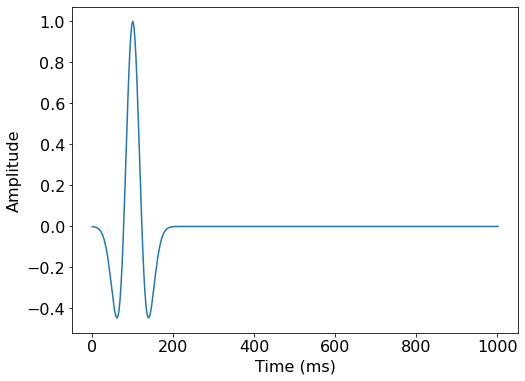

In [4]:
f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Set source coordinates
src.coordinates.data[0, 0] = np.array(model.domain_size[0]) * .5
src.coordinates.data[0, 1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet via:
src.show()

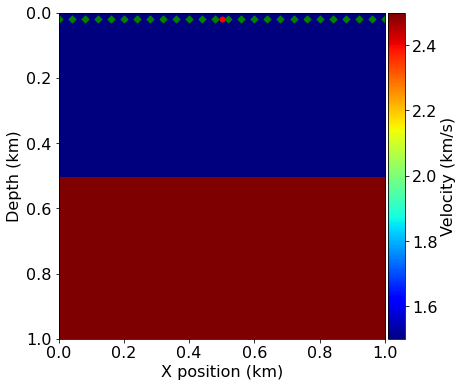

In [5]:
# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

In [6]:
# RickerSource and Receiver are thin wrappers around Devito's SparseTimeFunction type, 
# which encapsulates sparse point data and allows us to inject and interpolate values 
# into and out of the computational grid.

In [7]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [8]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
stencil = Eq(u.forward, solve(pde, u.forward))

In [9]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [10]:
# now create the Devito operator that will generate the C code at runtime
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

# The argument subs=model.spacing_map causes the operator to substitute values for our current grid 
# spacing into the expressions before code generation. This reduces the number of floating point 
# operations executed by the kernel by pre-evaluating certain coefficients.

In [11]:
# execute the created operator for a number of timesteps
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.02 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.008078000000000016, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.004624999999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.003094000000000016, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

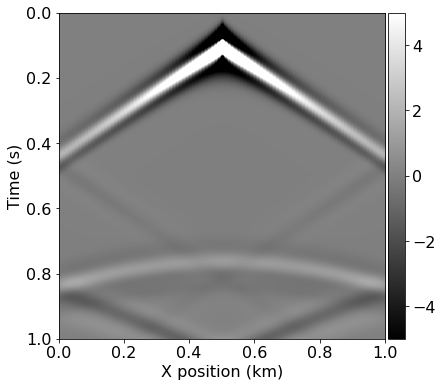

In [12]:
plot_shotrecord(rec.data, model, t0, tn, colorbar=True)

In [13]:
assert np.isclose(np.linalg.norm(rec.data), 370, rtol=1e-3)